In [1]:
import joblib

#joblib.parallel_backend("threading")

In [2]:
"""
%cd /kaggle/working
#!git clone https://github.com/R-N/ml-utility-loss --depth=1 --single-branch --branch=main
%cd ml-utility-loss
!git pull
#!pip install .
!pip install . --no-deps --force-reinstall --upgrade
#"""

'\n%cd /kaggle/working\n#!git clone https://github.com/R-N/ml-utility-loss --depth=1 --single-branch --branch=main\n%cd ml-utility-loss\n!git pull\n#!pip install .\n!pip install . --no-deps --force-reinstall --upgrade\n#'

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

In [4]:
datasets = [
    "insurance",
    "treatment",
    "contraceptive"
]

study_dir = "./"

In [5]:
#Parameters
import os

path_prefix = "../../../../"

dataset_dir = os.path.join(path_prefix, "ml-utility-loss/datasets")
dataset_name = "treatment"
model_name="ml_utility_2"
models = ["tvae", "realtabformer", "lct_gan", "tab_ddpm_concat"]
single_model = "lct_gan"
random_seed = 42
gp = True
gp_multiply = True
folder = "eval"
debug = False
path = None
param_index = 0
allow_same_prediction = True
log_wandb = False

In [6]:
# Parameters
dataset = "contraceptive"
dataset_name = "contraceptive"
single_model = "lct_gan"
gp = True
gp_multiply = True
random_seed = 1
debug = False
folder = "eval"
path_prefix = "../../../../"
path = "eval/contraceptive/lct_gan/1"
param_index = 0
allow_same_prediction = True
log_wandb = False


In [7]:
from pathlib import Path
import os

%cd /kaggle/working/

if path is None:
    path = os.path.join(folder, dataset_name, single_model, random_seed)
Path(path).mkdir(parents=True, exist_ok=True)

%cd {path}

/kaggle/working
/kaggle/working/eval/contraceptive/lct_gan/1


In [8]:
from ml_utility_loss.util import seed
if single_model:
    model_name=f"{model_name}_{single_model}"
if random_seed is not None:
    seed(random_seed)
    print("Set seed to", seed)

Set seed to <function seed at 0x7a99ed023370>


In [9]:
import pandas as pd
import numpy as np
import json
import os

df = pd.read_csv(os.path.join(dataset_dir, f"{dataset_name}.csv"))
with open(os.path.join(dataset_dir, f"{dataset_name}.json")) as f:
    info = json.load(f)

In [10]:
task = info["task"]
target = info["target"]
cat_features = info["cat_features"]
mixed_features = info["mixed_features"]
longtail_features = info["longtail_features"]
integer_features = info["integer_features"]

test = df.sample(frac=0.2, random_state=42)
train = df[~df.index.isin(test.index)]

In [11]:
import ml_utility_loss.synthesizers.tab_ddpm.params as TAB_DDPM_PARAMS
import ml_utility_loss.synthesizers.lct_gan.params as LCT_GAN_PARAMS
import ml_utility_loss.synthesizers.realtabformer.params as RTF_PARAMS
from ml_utility_loss.synthesizers.realtabformer.params.default import GPT2_PARAMS, REALTABFORMER_PARAMS
from ml_utility_loss.util import filter_dict_2, filter_dict

tab_ddpm_params = getattr(TAB_DDPM_PARAMS, dataset_name).BEST
lct_gan_params = getattr(LCT_GAN_PARAMS, dataset_name).BEST
lct_ae_params = filter_dict_2(lct_gan_params, LCT_GAN_PARAMS.default.AE_PARAMS)
rtf_params = getattr(RTF_PARAMS, dataset_name).BEST
rtf_params = filter_dict(rtf_params, REALTABFORMER_PARAMS)

lct_ae_embedding_size=lct_gan_params["embedding_size"]
tab_ddpm_normalization="quantile"
tab_ddpm_cat_encoding=tab_ddpm_params["cat_encoding"]
#tab_ddpm_cat_encoding="one-hot"
tab_ddpm_y_policy="default"
tab_ddpm_is_y_cond=True

In [12]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_lct_ae

lct_ae = load_lct_ae(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="lct_ae",
    df_name="df",
)
lct_ae = None

2024-03-22 19:40:19.417436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 19:40:19.417493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 19:40:19.419102: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_rtf_embed

rtf_embed = load_rtf_embed(
    dataset_name=dataset_name,
    model_dir=os.path.join(path_prefix, "ml-utility-loss/models"),
    model_name="realtabformer",
    df_name="df",
    ckpt_type="best-disc-model"
)

In [14]:
from ml_utility_loss.loss_learning.estimator.preprocessing import DataPreprocessor

preprocessor = DataPreprocessor(
    task,
    target=target,
    cat_features=cat_features,
    mixed_features=mixed_features,
    longtail_features=longtail_features,
    integer_features=integer_features,
    lct_ae_embedding_size=lct_ae_embedding_size,
    lct_ae_params=lct_ae_params,
    lct_ae=lct_ae,
    tab_ddpm_normalization=tab_ddpm_normalization,
    tab_ddpm_cat_encoding=tab_ddpm_cat_encoding,
    tab_ddpm_y_policy=tab_ddpm_y_policy,
    tab_ddpm_is_y_cond=tab_ddpm_is_y_cond,
    realtabformer_embedding=rtf_embed,
    realtabformer_params=rtf_params,
)
preprocessor.fit(df)

/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:119: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)


In [15]:
preprocessor.adapter_sizes

{'tvae': 46,
 'realtabformer': (24, 72, Embedding(72, 672), True),
 'lct_gan': 40,
 'tab_ddpm_concat': 10}

In [16]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_3_factory

datasetsn = load_dataset_3_factory(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    cache_dir=path_prefix,
)


In [17]:
from ml_utility_loss.loss_learning.estimator.pipeline import load_dataset_4

test_set = load_dataset_4(
    dataset_dir=os.path.join(path_prefix, "ml-utility-loss/"),
    dataset_name=dataset_name,
    preprocessor=preprocessor,
    model=single_model,
    cache_dir=path_prefix,
)

Caching in ../../../../contraceptive/_cache_aug_test/lct_gan/all inf False
../../../../ml-utility-loss/aug_test/contraceptive [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Caching in ../../../../contraceptive/_cache_bs_test/lct_gan/all inf False
../../../../ml-utility-loss/bs_test/contraceptive [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

../../../../ml-utility-loss/synthetics/contraceptive [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [18]:
import ml_utility_loss.loss_learning.estimator.params2 as PARAMS
from ml_utility_loss.tuning import map_parameters
from ml_utility_loss.loss_learning.estimator.params.default import update_param_space, update_param_space_2
import wandb

#"""
param_space = {
    **getattr(PARAMS, dataset_name).PARAM_SPACE,
}
params = {
    **getattr(PARAMS, dataset_name).BESTS[param_index],
}
if gp:
    params["gradient_penalty_mode"] = "ALL"
    params["mse_mag"] = True
    if gp_multiply:
        params["mse_mag_multiply"] = True
        #params["mse_mag_target"] = 1.0
    else:
        params["mse_mag_multiply"] = False
        #params["mse_mag_target"] = 0.1
else:
    params["gradient_penalty_mode"] = "NONE"
    params["mse_mag"] = False
params["single_model"] = False
if models:
    params["models"] = models
if single_model:
    params["fixed_role_model"] = single_model
    params["single_model"] = True
    params["models"] = [single_model]
if params["fixed_role_model"] == "realtabformer" and dataset_name == "treatment":
    params["batch_size"] = 2
params["max_seconds"] = 3600
params["patience"] = 10
params["epochs"] = 100
if debug:
    params["epochs"] = 2
with open("params.json", "w") as f:
    json.dump(params, f)
params = map_parameters(params, param_space=param_space)
params

{'Body': 'twin_encoder',
 'loss_balancer_meta': True,
 'loss_balancer_log': False,
 'loss_balancer_lbtw': False,
 'pma_skip_small': False,
 'isab_skip_small': False,
 'layer_norm': False,
 'pma_layer_norm': False,
 'attn_residual': True,
 'tf_n_layers_dec': False,
 'tf_isab_rank': 0,
 'tf_layer_norm': False,
 'tf_pma_start': -1,
 'head_n_seeds': 0,
 'tf_pma_low': 16,
 'dropout': 0,
 'combine_mode': 'diff_left',
 'tf_isab_mode': 'separate',
 'grad_loss_fn': <function torch.nn.functional.l1_loss(input: torch.Tensor, target: torch.Tensor, size_average: Optional[bool] = None, reduce: Optional[bool] = None, reduction: str = 'mean') -> torch.Tensor>,
 'single_model': True,
 'bias': True,
 'bias_final': True,
 'pma_ffn_mode': 'none',
 'patience': 10,
 'inds_init_mode': 'fixnorm',
 'grad_clip': 0.73,
 'gradient_penalty_mode': {'gradient_penalty': True,
  'forward_once': False,
  'calc_grad_m': False,
  'avg_non_role_model_m': False,
  'inverse_avg_non_role_model_m': False},
 'synth_data': 2,
 

In [19]:
train_set, val_set = datasetsn(model=params["fixed_role_model"], synth_data=params["synth_data"])

Caching in ../../../../contraceptive/_cache_aug_train/lct_gan/all inf False
split df ratio is 0
../../../../ml-utility-loss/aug_train/contraceptive [400, 0]
Caching in ../../../../contraceptive/_cache_aug_val/lct_gan/all inf False
split df ratio is 1
../../../../ml-utility-loss/aug_val/contraceptive [0, 200]
Caching in ../../../../contraceptive/_cache_bs_train/lct_gan/all inf False
split df ratio is 0
../../../../ml-utility-loss/bs_train/contraceptive [100, 0]
Caching in ../../../../contraceptive/_cache_bs_val/lct_gan/all inf False
split df ratio is 1
../../../../ml-utility-loss/bs_val/contraceptive [0, 50]
Caching in ../../../../contraceptive/_cache_synth/lct_gan/all inf False
Splitting without random!
Split with reverse index!
../../../../ml-utility-loss/synthetics/contraceptive [400, 200]
[900, 450]
[900, 450]


In [20]:
from ml_utility_loss.loss_learning.estimator.model.pipeline import remove_non_model_params
from ml_utility_loss.loss_learning.estimator.pipeline import create_model
from ml_utility_loss.util import filter_dict, clear_memory

clear_memory()

params2 = remove_non_model_params(params)
adapters = filter_dict(preprocessor.adapter_sizes, params["models"])

model = create_model(
    adapters=adapters,
    #Body="twin_encoder",
    **params2,
)
#cf.apply_weight_standardization(model, n_last_layers_ignore=0)
print(model.models, len(model.adapters))

Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>


[*] Embedding False True
['lct_gan'] 1


In [21]:
study_name=f"{model_name}_{dataset_name}"

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11889160

In [23]:
from torchinfo import summary

role_model = params["fixed_role_model"]
s = train_set[0][role_model]
summary(model[role_model], input_size=((2, *s[0].shape), (2, *s[1].shape)), depth=9) # 8 max

Layer (type:depth-idx)                                                 Output Shape              Param #
MLUtilitySingle                                                        [2, 1179, 40]             --
├─Adapter: 1-1                                                         [2, 1179, 40]             --
│    └─Sequential: 2-1                                                 [2, 1179, 256]            --
│    │    └─FeedForward: 3-1                                           [2, 1179, 1024]           --
│    │    │    └─Linear: 4-1                                           [2, 1179, 1024]           41,984
│    │    │    └─Softsign: 4-2                                         [2, 1179, 1024]           --
│    │    └─FeedForward: 3-2                                           [2, 1179, 1024]           --
│    │    │    └─Linear: 4-3                                           [2, 1179, 1024]           1,049,600
│    │    │    └─Softsign: 4-4                                         [2, 1179, 102

In [24]:
import torch
from ml_utility_loss.loss_learning.estimator.pipeline import train, train_2
from ml_utility_loss.loss_learning.estimator.process_simple import train_epoch, eval as _eval
from ml_utility_loss.params import GradientPenaltyMode
from ml_utility_loss.util import clear_memory
import time
#torch.autograd.set_detect_anomaly(True)

del model
clear_memory()

#opt = params["Optim"](model.parameters())
loss = train_2(
    [train_set, val_set, test_set],
    preprocessor=preprocessor,
    #whole_model=model,
    #optim=opt,
    log_dir="logs",
    checkpoint_dir="checkpoints",
    verbose=True,
    allow_same_prediction=allow_same_prediction,
    wandb=wandb if log_wandb else None,
    study_name=study_name,
    **params
)

3 datasets [900, 450, 1050]
Creating model of type <class 'ml_utility_loss.loss_learning.estimator.model.models.TwinEncoder'>
[*] Embedding False True
g_loss_mul 0.1
Epoch 0


Train loss {'avg_role_model_loss': 0.017401078423782666, 'avg_role_model_std_loss': 1.0339260609464513, 'avg_role_model_mean_pred_loss': 0.0010806548900643828, 'avg_role_model_g_mag_loss': 0.16402181821875275, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.01764664788174236, 'n_size': 900, 'n_batch': 225, 'duration': 261.55655670166016, 'duration_batch': 1.1624735853407118, 'duration_size': 0.29061839633517794, 'avg_pred_std': 0.1123641776252124}


Val loss {'avg_role_model_loss': 0.016450096456747915, 'avg_role_model_std_loss': 1.6555652437911634, 'avg_role_model_mean_pred_loss': 0.0006544369515005302, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.016450096456747915, 'n_size': 450, 'n_batch': 113, 'duration': 90.59106540679932, 'duration_batch': 0.8016908443079586, 'duration_size': 0.20131347868177626, 'avg_pred_std': 0.10719071906595697}
Epoch 1


Train loss {'avg_role_model_loss': 0.007544516106006793, 'avg_role_model_std_loss': 0.805866371501884, 'avg_role_model_mean_pred_loss': 0.00011455891246516556, 'avg_role_model_g_mag_loss': 0.05731394776852944, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007670205862442446, 'n_size': 900, 'n_batch': 225, 'duration': 262.5022921562195, 'duration_batch': 1.1666768540276422, 'duration_size': 0.29166921350691055, 'avg_pred_std': 0.08921317261954148}


Val loss {'avg_role_model_loss': 0.004202535958288031, 'avg_role_model_std_loss': 0.7761073129848487, 'avg_role_model_mean_pred_loss': 4.496906836265167e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.004202535958288031, 'n_size': 450, 'n_batch': 113, 'duration': 90.03428149223328, 'duration_batch': 0.796763553028613, 'duration_size': 0.20007618109385172, 'avg_pred_std': 0.058546484567521685}
Epoch 2


Train loss {'avg_role_model_loss': 0.006512888989463035, 'avg_role_model_std_loss': 0.7518540992810281, 'avg_role_model_mean_pred_loss': 0.0001415838299930615, 'avg_role_model_g_mag_loss': 0.049427424324288344, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0066497801841857536, 'n_size': 900, 'n_batch': 225, 'duration': 262.3658037185669, 'duration_batch': 1.1660702387491861, 'duration_size': 0.29151755968729653, 'avg_pred_std': 0.09130782820491327}


Val loss {'avg_role_model_loss': 0.0055336219292237525, 'avg_role_model_std_loss': 1.1570013584530916, 'avg_role_model_mean_pred_loss': 6.174433674384281e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0055336219292237525, 'n_size': 450, 'n_batch': 113, 'duration': 89.11512207984924, 'duration_batch': 0.788629398936719, 'duration_size': 0.1980336046218872, 'avg_pred_std': 0.04651118999973467}
Epoch 3


Train loss {'avg_role_model_loss': 0.006024511704712899, 'avg_role_model_std_loss': 0.4761890591268285, 'avg_role_model_mean_pred_loss': 0.0002143375033454278, 'avg_role_model_g_mag_loss': 0.06465743926004507, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0061261716642830935, 'n_size': 900, 'n_batch': 225, 'duration': 260.4550771713257, 'duration_batch': 1.1575781207614475, 'duration_size': 0.2893945301903619, 'avg_pred_std': 0.09767564491679272}


Val loss {'avg_role_model_loss': 0.004724722134932462, 'avg_role_model_std_loss': 0.7707038955945308, 'avg_role_model_mean_pred_loss': 5.621562246012167e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.004724722134932462, 'n_size': 450, 'n_batch': 113, 'duration': 87.9228572845459, 'duration_batch': 0.7780783830490787, 'duration_size': 0.19538412729899088, 'avg_pred_std': 0.056170098961586444}
Epoch 4


Train loss {'avg_role_model_loss': 0.005286015553380518, 'avg_role_model_std_loss': 0.3363608939476823, 'avg_role_model_mean_pred_loss': 7.321617665753689e-05, 'avg_role_model_g_mag_loss': 0.045423433695816334, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.005374089340039063, 'n_size': 900, 'n_batch': 225, 'duration': 260.1741499900818, 'duration_batch': 1.1563295555114745, 'duration_size': 0.28908238887786863, 'avg_pred_std': 0.09759037269486322}


Val loss {'avg_role_model_loss': 0.007981064757849607, 'avg_role_model_std_loss': 1.2652324522273108, 'avg_role_model_mean_pred_loss': 9.855836417115466e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.007981064757849607, 'n_size': 450, 'n_batch': 113, 'duration': 88.88254165649414, 'duration_batch': 0.7865711651017181, 'duration_size': 0.19751675923665366, 'avg_pred_std': 0.04572650106969924}
Epoch 5


Train loss {'avg_role_model_loss': 0.00576256091059703, 'avg_role_model_std_loss': 0.5418789782114618, 'avg_role_model_mean_pred_loss': 7.038583156805957e-05, 'avg_role_model_g_mag_loss': 0.02929313911823556, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.005917770875255681, 'n_size': 900, 'n_batch': 225, 'duration': 262.8189432621002, 'duration_batch': 1.168084192276001, 'duration_size': 0.29202104806900026, 'avg_pred_std': 0.09744484349257417}


Val loss {'avg_role_model_loss': 0.0038669909037222774, 'avg_role_model_std_loss': 1.1829836725373764, 'avg_role_model_mean_pred_loss': 2.4478697872928952e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0038669909037222774, 'n_size': 450, 'n_batch': 113, 'duration': 90.46491193771362, 'duration_batch': 0.8005744419266693, 'duration_size': 0.20103313763936362, 'avg_pred_std': 0.047730479976656824}
Epoch 6


Train loss {'avg_role_model_loss': 0.0038541355246626253, 'avg_role_model_std_loss': 0.3181302580921152, 'avg_role_model_mean_pred_loss': 2.260195795584597e-05, 'avg_role_model_g_mag_loss': 0.02967498921504658, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003917783604055229, 'n_size': 900, 'n_batch': 225, 'duration': 261.9046974182129, 'duration_batch': 1.1640208774142795, 'duration_size': 0.2910052193535699, 'avg_pred_std': 0.10003261071940263}


Val loss {'avg_role_model_loss': 0.0038603629919493365, 'avg_role_model_std_loss': 1.908042863952322, 'avg_role_model_mean_pred_loss': 1.606306340802302e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0038603629919493365, 'n_size': 450, 'n_batch': 113, 'duration': 90.71723699569702, 'duration_batch': 0.8028074070415666, 'duration_size': 0.20159385999043783, 'avg_pred_std': 0.05183640702017706}
Epoch 7


Train loss {'avg_role_model_loss': 0.003702066924338902, 'avg_role_model_std_loss': 0.2994743646377197, 'avg_role_model_mean_pred_loss': 2.3150445486223394e-05, 'avg_role_model_g_mag_loss': 0.018106737517001523, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0037678834933709974, 'n_size': 900, 'n_batch': 225, 'duration': 260.3814172744751, 'duration_batch': 1.1572507434421115, 'duration_size': 0.2893126858605279, 'avg_pred_std': 0.10073738541454076}


Val loss {'avg_role_model_loss': 0.0028049794745553906, 'avg_role_model_std_loss': 1.4249755061280251, 'avg_role_model_mean_pred_loss': 1.3086192913582816e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0028049794745553906, 'n_size': 450, 'n_batch': 113, 'duration': 90.54383492469788, 'duration_batch': 0.8012728754398042, 'duration_size': 0.20120852205488418, 'avg_pred_std': 0.054640445479117665}
Epoch 8


Train loss {'avg_role_model_loss': 0.0033579401259905555, 'avg_role_model_std_loss': 0.3882562007228762, 'avg_role_model_mean_pred_loss': 1.8571260889600453e-05, 'avg_role_model_g_mag_loss': 0.031065790198707772, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0034128941754655293, 'n_size': 900, 'n_batch': 225, 'duration': 261.0693860054016, 'duration_batch': 1.1603083822462295, 'duration_size': 0.29007709556155736, 'avg_pred_std': 0.10073215851146314}


Val loss {'avg_role_model_loss': 0.004292678962616871, 'avg_role_model_std_loss': 2.506649698973513, 'avg_role_model_mean_pred_loss': 4.666494623541402e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.004292678962616871, 'n_size': 450, 'n_batch': 113, 'duration': 89.04813385009766, 'duration_batch': 0.788036582744227, 'duration_size': 0.1978847418891059, 'avg_pred_std': 0.05573896699857}
Epoch 9


Train loss {'avg_role_model_loss': 0.0032293959062533557, 'avg_role_model_std_loss': 0.4635296431291696, 'avg_role_model_mean_pred_loss': 1.8672718882848967e-05, 'avg_role_model_g_mag_loss': 0.023970585422034167, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.003291322695731651, 'n_size': 900, 'n_batch': 225, 'duration': 260.9506549835205, 'duration_batch': 1.1597806888156468, 'duration_size': 0.2899451722039117, 'avg_pred_std': 0.10359380051907566}


Val loss {'avg_role_model_loss': 0.002744582254672423, 'avg_role_model_std_loss': 2.2099234429464625, 'avg_role_model_mean_pred_loss': 2.5944116722460305e-05, 'avg_role_model_g_mag_loss': 0.0, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.002744582254672423, 'n_size': 450, 'n_batch': 113, 'duration': 89.43556237220764, 'duration_batch': 0.7914651537363508, 'duration_size': 0.19874569416046142, 'avg_pred_std': 0.05300469076635926}
Epoch 10


Train loss {'avg_role_model_loss': 0.0026384538486470574, 'avg_role_model_std_loss': 0.23855205940207644, 'avg_role_model_mean_pred_loss': 1.205315517315884e-05, 'avg_role_model_g_mag_loss': 0.024326985160069953, 'avg_role_model_g_cos_loss': 0.0, 'avg_non_role_model_g_mag_loss': 0.0, 'avg_non_role_model_g_cos_loss': 0.0, 'avg_non_role_model_embed_loss': 0.0, 'avg_loss': 0.0026762135176815922, 'n_size': 900, 'n_batch': 225, 'duration': 263.52970361709595, 'duration_batch': 1.1712431271870931, 'duration_size': 0.2928107817967733, 'avg_pred_std': 0.10776877377182245}
Time out: 3785.1640882492065/3600


Eval loss {'role_model': 'lct_gan', 'n_size': 1050, 'n_batch': 263, 'role_model_metrics': {'avg_loss': 0.002836061065248768, 'avg_g_mag_loss': 0.04869947255703835, 'avg_g_cos_loss': 0.010633710139164967, 'pred_duration': 4.068113565444946, 'grad_duration': 12.533695220947266, 'total_duration': 16.601808786392212, 'pred_std': 0.1082986444234848, 'std_loss': 0.0010494085727259517, 'mean_pred_loss': 9.070246051123831e-06, 'pred_rmse': 0.05325468257069588, 'pred_mae': 0.04161286726593971, 'pred_mape': 0.12254984676837921, 'grad_rmse': 0.1400071233510971, 'grad_mae': 0.03379097580909729, 'grad_mape': 0.8471567034721375}, 'non_role_model_metrics': {'avg_loss': 0, 'avg_g_mag_loss': 0, 'avg_g_cos_loss': 0, 'avg_pred_duration': 0, 'avg_grad_duration': 0, 'avg_total_duration': 0, 'avg_pred_std': 0, 'avg_std_loss': 0, 'avg_mean_pred_loss': 0}, 'avg_metrics': {'avg_loss': 0.002836061065248768, 'avg_g_mag_loss': 0.04869947255703835, 'avg_g_cos_loss': 0.010633710139164967, 'avg_pred_duration': 4.068

In [25]:
model = loss["whole_model"]
opt = loss["optim"]

In [26]:
import torch
from copy import deepcopy

torch.save(deepcopy(model.state_dict()), "model.pt")
#torch.save(deepcopy(opt.state_dict()), "optim.pt")

<Axes: >

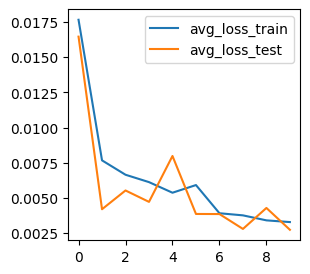

In [27]:
history = loss["history"]
history.to_csv("history.csv")
history[["avg_loss_train", "avg_loss_test"]].plot()

In [28]:

from ml_utility_loss.loss_learning.estimator.pipeline import eval
#eval_loss = loss["eval_loss"]

batch_size = params["batch_size_low"] if "batch_size_low" in params else params["batch_size"]

eval_loss = eval(
    test_set, model,
    batch_size=batch_size,
)

In [29]:
import pandas as pd

metrics = pd.DataFrame(eval_loss["model_metrics"]).T
metrics.to_csv("eval.csv")
metrics

avg_g_cos_loss  avg_g_mag_loss  avg_loss  grad_duration  grad_mae  \
lct_gan        0.005347        0.080971  0.002836      12.467301  0.033791   

         grad_mape  grad_rmse  mean_pred_loss  pred_duration  pred_mae  \
lct_gan   0.847157   0.140007        0.000009       4.109843  0.041613   

         pred_mape  pred_rmse  pred_std  std_loss  total_duration  
lct_gan    0.12255   0.053255  0.108299  0.001049       16.577143

In [30]:
from ml_utility_loss.util import clear_memory
clear_memory()

In [31]:
#"""
from ml_utility_loss.loss_learning.estimator.process import pred, pred_2
from ml_utility_loss.util import stack_samples

#samples = test_set[list(range(len(test_set)))]
#y = {m: pred(model[m], s) for m, s in samples.items()}
y = pred_2(model, test_set, batch_size=batch_size)
#"""

Caching in ../../../../contraceptive/_cache_aug_test/lct_gan/all inf False
Caching in ../../../../contraceptive/_cache_bs_test/lct_gan/all inf False
Caching in ../../../../contraceptive/_cache_synth_test/lct_gan/all inf False


In [32]:
import os
import pandas as pd
from ml_utility_loss.util import transpose_dict

os.makedirs("pred", exist_ok=True)
y2 = transpose_dict(y)
for k, v in y2.items():
    df = pd.DataFrame(v)
    df.to_csv(f"pred/{k}.csv")

In [33]:
print({k: sum(v["pred"])/len(v["pred"]) for k, v in y.items()})

{'lct_gan': 0.3770567048447473}


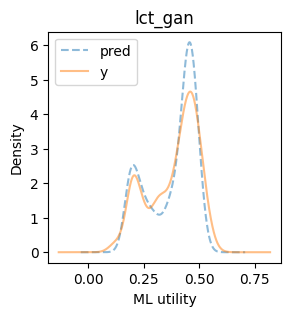

In [34]:
from ml_utility_loss.loss_learning.visualization import plot_pred_density_2

_ = plot_pred_density_2(y)

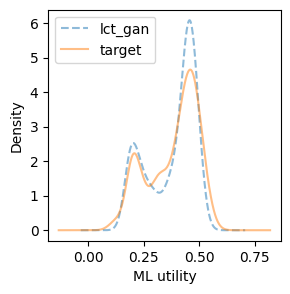

In [35]:
from ml_utility_loss.loss_learning.visualization import plot_density_3

_ = plot_density_3(y2["pred"], next(iter(y2["y"].values())))

In [36]:
from ml_utility_loss.loss_learning.visualization import plot_box_3

_ = plot_box_3(y2["pred"], next(iter(y2["y"].values())))

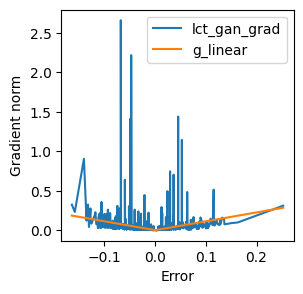

In [37]:
#"""
from ml_utility_loss.loss_learning.visualization import plot_grad, plot_grad_2, plot_grad_3
import matplotlib.pyplot as plt

#plot_grad_2(y, model.models)
for m in model.models:
    ym = y[m]
    fig, ax = plt.subplots()
    plot_grad_3(ym["error"], ym["grad"], name=f"{m}_grad", fig=fig, ax=ax)
#"""